[I 2025-04-21 13:39:55,655] A new study created in memory with name: no-name-0a6c9264-e994-4e30-b5b2-723665df3124


Clipped to 120 months: 2010-01-01 → 2019-12-01
Train: 114 mo  Hold‑out: 6 mo (2019-07-01→2019-12-01)
3 CV folds at starts: [96, 102, 108]


[I 2025-04-21 13:39:55,925] Trial 0 finished with value: 0.031185446878936957 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 52, 'delta_scale': 0.015958237752949748, 'gamma_scale': 1.6239780813448106, 'season_scale': 0.5871254182522991}. Best is trial 0 with value: 0.031185446878936957.
[I 2025-04-21 13:40:06,658] Trial 1 finished with value: 0.001289105592310097 and parameters: {'harm_year': 7, 'add_half': 1, 'harm_half': 1, 'n_cp': 78, 'delta_scale': 0.12106896936002161, 'gamma_scale': 1.8493564427131046, 'season_scale': 0.7727374508106509}. Best is trial 1 with value: 0.001289105592310097.
[I 2025-04-21 13:40:08,797] Trial 2 finished with value: 0.0011415407329172535 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 2, 'n_cp': 30, 'delta_scale': 0.06252287916406217, 'gamma_scale': 1.5579754426081673, 'season_scale': 0.9382169728028272}. Best is trial 2 with value: 0.0011415407329172535.
[I 2025-04-21 13:40:13,476] Trial 3 finished with value: 0.001137191414986979

Murphet CV RMSE: 0.0010167994111263264


[I 2025-04-21 13:48:20,495] Trial 0 finished with value: 0.0017002133154430485 and parameters: {'n_cp': 36, 'cp_range': 0.9853892897499337, 'cp_scale': 0.09454306819536169, 'sea_scale': 0.6251373574521749}. Best is trial 0 with value: 0.0017002133154430485.
Optimization terminated abnormally. Falling back to Newton.
[I 2025-04-21 13:48:20,823] Trial 1 finished with value: 0.006417046020098381 and parameters: {'n_cp': 21, 'cp_range': 0.8304189314655596, 'cp_scale': 0.001434715951720141, 'sea_scale': 3.9676050770529883}. Best is trial 0 with value: 0.0017002133154430485.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
[I 2025-04-21 13:48:21,528] Trial 2 finished with value: 0.006699195810141795 and parameters: {'n_cp': 52, 'cp_range': 0.9380741526702289, 'cp_scale': 0.001136467270001117, 'sea_scale': 8.123245085588687}. Best is trial 0 with value: 0.0017002133154430485.
Optimization terminated abnormally. Falling bac

Prophet CV RMSE: 0.0011829023240861206

Metrics:
          Train RMSE  Holdout RMSE  Holdout MAE  Holdout MAPE  Holdout SMAPE
Model                                                                      
Murphet      0.0009        0.0009       0.0008        2.1617          2.188
Prophet      0.0010        0.0016       0.0013        3.6672          3.767


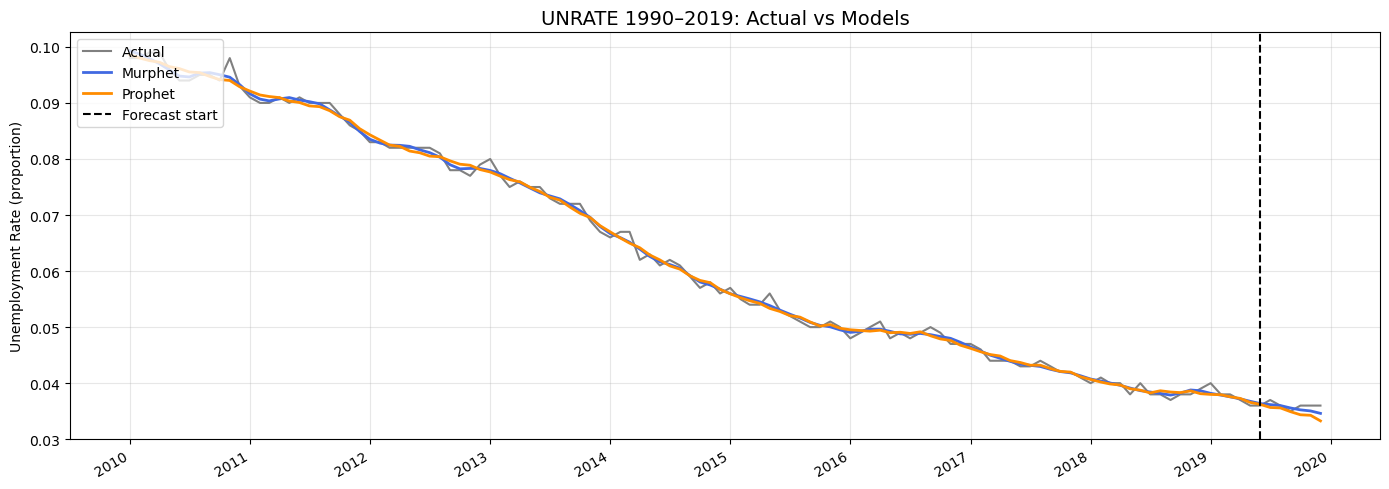

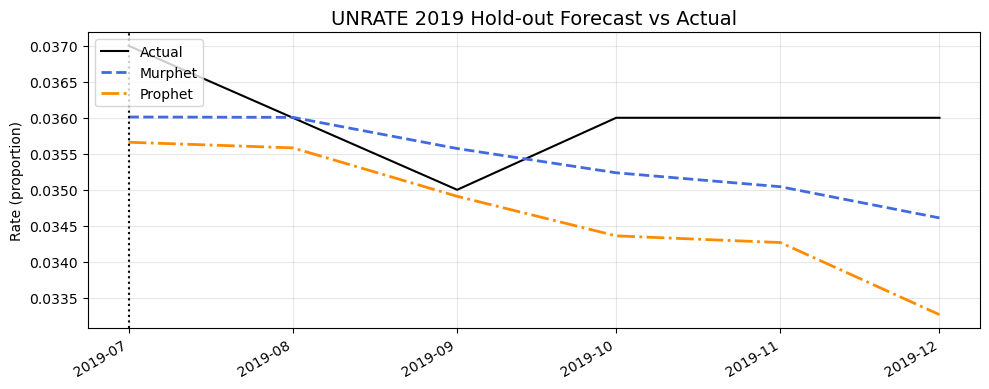

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import warnings
from pathlib import Path
from prophet import Prophet
from murphet import fit_churn_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore")
np.random.seed(42)

# ─────────────────────────────────────────────────────────────────────────────
# 1) Load & preprocess UNRATE
# ─────────────────────────────────────────────────────────────────────────────
ROOT      = Path().resolve()
DATA_PATH = ROOT / "data" / "UNRATE.csv"

df = (
    pd.read_csv(DATA_PATH, parse_dates=["observation_date"])
      .rename(columns={"observation_date":"ds","UNRATE":"y"})
)

# to proportion & clip
df["y"] = df["y"]/100.0
eps = 1e-5
df["y"] = df["y"].clip(eps,1-eps)

# keep only 1990–2019
df = df[(df.ds >= "2010-01-01") & (df.ds < "2020-01-01")].sort_values("ds")
df = df.reset_index(drop=True)
df["t"] = np.arange(len(df), dtype=float)

print(f"Clipped to {len(df)} months: {df.ds.min().date()} → {df.ds.max().date()}")

# ─────────────────────────────────────────────────────────────────────────────
# 2) Train / hold‑out split (last 12 mo)
# ─────────────────────────────────────────────────────────────────────────────
HOLDOUT_MO = 6
train_df   = df.iloc[:-HOLDOUT_MO].copy()
test_df    = df.iloc[-HOLDOUT_MO:].copy()

print(f"Train: {len(train_df)} mo  Hold‑out: {len(test_df)} mo ({test_df.ds.min().date()}→{test_df.ds.max().date()})")

# ─────────────────────────────────────────────────────────────────────────────
# 3) Rolling CV setup on train
# ─────────────────────────────────────────────────────────────────────────────
INIT_MONTHS = 96  # 10 yrs
CV_HORIZON  = 6   # 2 yrs
CV_STEP     = 6   # yearly slide

fold_starts = list(range(
    INIT_MONTHS,
    len(train_df) - CV_HORIZON + 1,
    CV_STEP
))
print(f"{len(fold_starts)} CV folds at starts: {fold_starts}")

# ─────────────────────────────────────────────────────────────────────────────
# 4) CV objective + search spaces
# ─────────────────────────────────────────────────────────────────────────────
def rmse(a,f): return np.sqrt(mean_squared_error(a,f))
def mae(a,f):  return mean_absolute_error(a,f)
def mape(a,f): return 100*np.mean(np.abs((a-f)/a))
def smape(a,f):return 100*np.mean(2*np.abs(f-a)/(np.abs(a)+np.abs(f)))

def mur_cfg(trial):
    periods = [12.0]
    harms   = [trial.suggest_int("harm_year",1,7)]
    if trial.suggest_categorical("add_half",[0,1]):
        periods.append(6.0)
        harms.append(trial.suggest_int("harm_half",1,3))
    return dict(
        likelihood="beta", periods=periods, num_harmonics=harms,
        n_changepoints=trial.suggest_int("n_cp",10,80),
        delta_scale=trial.suggest_float("delta_scale",0.01,0.2,log=True),
        gamma_scale=trial.suggest_float("gamma_scale",1.0,5.0),
        season_scale=trial.suggest_float("season_scale",0.5,2.0),
        inference="map", chains=2, iter=2000, warmup=0, seed=42,
    )

def prop_cfg(trial):
    return dict(
        n_changepoints=trial.suggest_int("n_cp",10,80),
        changepoint_range=trial.suggest_float("cp_range",0.8,0.995),
        changepoint_prior_scale=trial.suggest_float("cp_scale",0.001,0.5,log=True),
        seasonality_prior_scale=trial.suggest_float("sea_scale",0.01,10.0,log=True),
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        interval_width=0.8,
    )

def cv_objective(make_cfg,is_murphet):
    def obj(trial):
        cfg = make_cfg(trial)
        errs=[]
        for start in fold_starts:
            tr = train_df.iloc[:start]
            te = train_df.iloc[start:start+CV_HORIZON]
            try:
                if is_murphet:
                    m = fit_churn_model(t=tr.t.values,y=tr.y.values,**cfg)
                    pred = m.predict(te.t.values)
                else:
                    m = Prophet(**cfg)
                    m.fit(tr[["ds","y"]])
                    fut = m.make_future_dataframe(CV_HORIZON,freq="MS").iloc[-CV_HORIZON:]
                    pred= m.predict(fut)["yhat"].values
                errs.append(rmse(te.y.values,pred))
            except:
                return 1e6
        return float(np.mean(errs))
    return obj

# tune Murphet
mur = optuna.create_study(direction="minimize",sampler=optuna.samplers.TPESampler(seed=42))
mur.optimize(cv_objective(mur_cfg,True),n_trials=120)
best_mur = mur_cfg(mur.best_trial)
print("Murphet CV RMSE:",mur.best_value)

# tune Prophet
pp = optuna.create_study(direction="minimize",sampler=optuna.samplers.TPESampler(seed=42))
pp.optimize(cv_objective(prop_cfg,False),n_trials=120)
best_prop = prop_cfg(pp.best_trial)
print("Prophet CV RMSE:",pp.best_value)

# ─────────────────────────────────────────────────────────────────────────────
# 5) Final fit & predictions
# ─────────────────────────────────────────────────────────────────────────────
# Murphet full‐series & holdout
mur_model = fit_churn_model(t=train_df.t.values,y=train_df.y.values,**best_mur)
mur_full  = mur_model.predict(df.t.values)
mur_hold  = mur_model.predict(test_df.t.values)

# Prophet full‐series & holdout
prop_model = Prophet(**best_prop)
prop_model.fit(train_df[["ds","y"]])
full_prop_df = prop_model.predict(df[["ds"]])
prop_full    = full_prop_df["yhat"].values
fut          = prop_model.make_future_dataframe(periods=HOLDOUT_MO,freq="MS").iloc[-HOLDOUT_MO:]
prop_hold    = prop_model.predict(fut)["yhat"].values

# metrics
metrics = pd.DataFrame({
    "Model": ["Murphet","Prophet"],
    "Train RMSE": [rmse(train_df.y.values,mur_full[:len(train_df)]),
                   rmse(train_df.y.values,prop_full[:len(train_df)])],
    "Holdout RMSE":[rmse(test_df.y.values,mur_hold),
                    rmse(test_df.y.values,prop_hold)],
    "Holdout MAE":[mae(test_df.y.values,mur_hold),
                   mae(test_df.y.values,prop_hold)],
    "Holdout MAPE":[mape(test_df.y.values,mur_hold),
                    mape(test_df.y.values,prop_hold)],
    "Holdout SMAPE":[smape(test_df.y.values,mur_hold),
                     smape(test_df.y.values,prop_hold)]
}).set_index("Model").round(4)
print("\nMetrics:\n",metrics)

# ─────────────────────────────────────────────────────────────────────────────
# 6) Plot full‐series overlay
# ─────────────────────────────────────────────────────────────────────────────
fig,ax = plt.subplots(figsize=(14,5))
ax.plot(df.ds,df.y,         color="gray",      lw=1.5, label="Actual")
ax.plot(df.ds,mur_full,     color="royalblue", lw=2,   label="Murphet")
ax.plot(df.ds,prop_full,    color="darkorange", lw=2,   label="Prophet")
ax.axvline(train_df.ds.iloc[-1], ls="--",color="k", label="Forecast start")
ax.set_title("UNRATE 1990–2019: Actual vs Models",fontsize=14)
ax.set_ylabel("Unemployment Rate (proportion)")
ax.legend(loc="upper left"); ax.grid(alpha=0.3)
fig.autofmt_xdate(); plt.tight_layout(); plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# 7) Plot hold‑out zoom
# ─────────────────────────────────────────────────────────────────────────────
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(test_df.ds, test_df.y,    color="black",    lw=1.5, label="Actual")
ax.plot(test_df.ds, mur_hold,     color="royalblue",lw=2,   ls="--",label="Murphet")
ax.plot(test_df.ds, prop_hold,    color="darkorange",lw=2,   ls="-.",label="Prophet")
ax.axvline(test_df.ds.iloc[0], ls=":", color="k")
ax.set_title("UNRATE 2019 Hold‑out Forecast vs Actual",fontsize=14)
ax.set_ylabel("Rate (proportion)")
ax.legend(loc="upper left"); ax.grid(alpha=0.3)
fig.autofmt_xdate(); plt.tight_layout(); plt.show()
